# Statistical Analysis of Empirical Runtime Data
We will analyze two datasets to evaluate the empirical behavior of the algorithm: one in which the divisor size $m$ is 
held constant and the dividend size $n$ varies, and the other in which the dividend size $n$ is held constant and the
divisor size $m$ varies.

Assuming arithmetic operations have complexity $\mathcal{O}(m)$, we expect to see behavior approximately modeled by 

$$F_1(n,m) = m(n-m) = nm - m^2$$

For constant $m$, we expect to observe a positive linear relationship between $n$ and runtime:

$$F(n) \approx n$$

For constant $n$, we expect to observe an inverse quadratic relationship between $m$ and runtime:

$$F(m) \approx - m^2 + m$$

In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import skew, kurtosis, kurtosistest
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import shapiro
%matplotlib inline

# Variable Dividend Size: $n = \{12, 13, ..., 10000\}, m = 10$

In [19]:
dividend_df = pd.read_csv('dividend_log.txt', header=None)
dividend_df = pd.DataFrame(dividend_df[0].str.split().tolist()).astype(int)
dividend_df.columns = ['return_value', 'dividend_size', 'divisor_size', 'runtime']
dividend_df['len_diff'] = dividend_df['dividend_size'] - dividend_df['divisor_size']
dividend_df

,return_value,dividend_size,divisor_size,runtime,len_diff
0,1,10000,1,6,9999
1,1,9999,2,6,9997
2,1,9998,3,7,9995
3,1,9997,4,9,9993
4,1,9996,5,11,9991
...,...,...,...,...,...
1427,1,8573,1428,1510,7145
1428,1,8572,1429,1509,7143
1429,1,8571,1430,1505,7141
1430,1,8570,1431,1524,7139


## Plot with $F(n)$
We observe a positive, approximately linear relationship with a fair amount of longer runtimes.

                            OLS Regression Results                            
Dep. Variable:                runtime   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     1927.
Date:                Mon, 22 Feb 2021   Prob (F-statistic):          2.76e-267
Time:                        10:47:26   Log-Likelihood:                -10623.
No. Observations:                1432   AIC:                         2.125e+04
Df Residuals:                    1430   BIC:                         2.126e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5737.5270    111.013     51.683      0.0

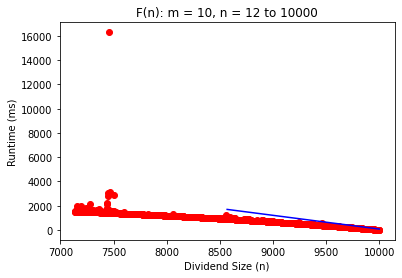

In [20]:
# dividend_df['len_diff_sq'] = dividend_df['len_diff']**2
# dividend_df['runtime'] = np.log(dividend_df['runtime'].replace(0, 1))
results = smf.ols(formula='runtime ~ len_diff', data=dividend_df).fit()
dividend_df['regression'] = results.fittedvalues
dividend_df['error'] = dividend_df['runtime'] - dividend_df['regression']
# print(shapiro(dividend_df['error']))
plt.scatter(dividend_df['len_diff'], dividend_df['runtime'], color='red') 
plt.title('F(n): m = 10, n = 12 to 10000')
plt.xlabel('Dividend Size (n)')
plt.ylabel('Runtime (ms)')
plt.plot(dividend_df['dividend_size'], dividend_df['regression'], color='blue')
print(results.summary())
plt.savefig('dividend.png')

(array([228., 264., 295., 364., 260.,  11.,   5.,   0.,   2.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([6.000000e+00, 3.319200e+02, 6.578400e+02, 9.837600e+02,
        1.309680e+03, 1.635600e+03, 1.961520e+03, 2.287440e+03,
        2.613360e+03, 2.939280e+03, 3.265200e+03, 3.591120e+03,
        3.917040e+03, 4.242960e+03, 4.568880e+03, 4.894800e+03,
        5.220720e+03, 5.546640e+03, 5.872560e+03, 6.198480e+03,
        6.524400e+03, 6.850320e+03, 7.176240e+03, 7.502160e+03,
        7.828080e+03, 8.154000e+03, 8.479920e+03, 8.805840e+03,
        9.131760e+03, 9.457680e+03, 9.783600e+03, 1.010952e+04,
        1.043544e+04, 1.076136e+04, 1.108728e+04, 1.141320e+04,
        1.173912e+04, 1.206504e+04, 1.239096e+04, 1.271688e+04,
        1.304280e+

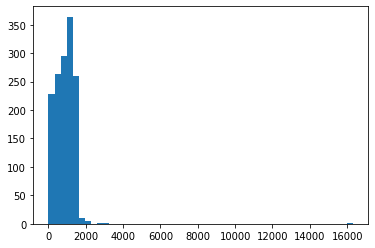

In [21]:
plt.hist(dividend_df['runtime'], bins=50)

In [22]:
print(f'runtime skew = {skew(dividend_df["runtime"])}')
print(f'runtime kurtosis {kurtosis(dividend_df["runtime"], fisher=False)}')

runtime skew = 10.854739740962625
runtime kurtosis 271.6154578427419


In [23]:
results.tvalues

Intercept    51.683245
len_diff    -43.899274
dtype: float64

## Evaluate $F(n)$ Error Behavior

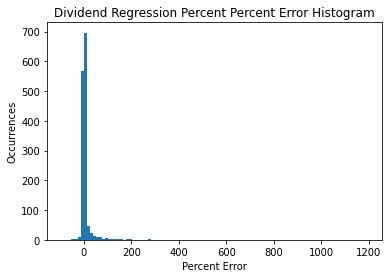

In [24]:
dividend_df['runtime'] = dividend_df['runtime'].replace(0, .1)  # Avoid division by 0
dividend_df['pct_err'] = 100*(dividend_df['regression'] - dividend_df['runtime'])/dividend_df['runtime']
hist = np.histogram(dividend_df['pct_err'], 100)
plt.hist(dividend_df['pct_err'], bins=100)
plt.title('Dividend Regression Percent Percent Error Histogram')
plt.xlabel('Percent Error')
plt.ylabel('Occurrences')
plt.savefig('dividend_hist.png')

## Sample Statistical Moments
Sample moments indicate high peak with large tails, and slight negative skew - a tendency to underestimate runtimes.

In [25]:
print('1st ORDER REGRESSION PERCENT ERROR:')
print(f'Mean = {round(np.mean(dividend_df["pct_err"]), 3)}')
print(f'Variance = {round(np.var(dividend_df["pct_err"]), 3)}')
print(f'Skew = {round(skew(dividend_df["pct_err"]), 3)}')
print(f'Kurtosis = {round(kurtosis(dividend_df["pct_err"]), 3)}')

1st ORDER REGRESSION PERCENT ERROR:
Mean = 11.529
Variance = 5007.277
Skew = 11.254
Kurtosis = 154.075


In [26]:
dividend_df['pct_err'].describe()

count    1432.000000
mean       11.529315
std        70.786838
min       -90.717044
25%        -2.832705
50%         0.634864
75%         5.884113
max      1191.531614
Name: pct_err, dtype: float64

# Variable Divisor Size: $m = \{2, 3, ..., 9999\}, n = 10000$

In [27]:
divisor_df = pd.read_csv('divisor_log.txt', header=None)
divisor_df = pd.DataFrame(divisor_df[0].str.split().tolist()).astype(int) 
divisor_df.columns = ['return_value', 'dividend_size', 'divisor_size','runtime'] 
divisor_df

,return_value,dividend_size,divisor_size,runtime
0,1,10000,2,6
1,1,10000,3,7
2,1,10000,4,9
3,1,10000,5,10
4,1,10000,6,12
...,...,...,...,...
9993,1,10000,9995,92
9994,1,10000,9996,92
9995,1,10000,9997,92
9996,1,10000,9998,89


## Fit 2nd Order Polynomial to Dataset - $F(m) \approx - m^2 + m$

## Plot with $F(m)$
We observe a negative quadratic relationship with a trace amount of extreme runtimes.

                            OLS Regression Results                            
Dep. Variable:                runtime   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 7.029e+05
Date:                Mon, 22 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:47:27   Log-Likelihood:                -59863.
No. Observations:                9998   AIC:                         1.197e+05
Df Residuals:                    9995   BIC:                         1.198e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -11.2542    

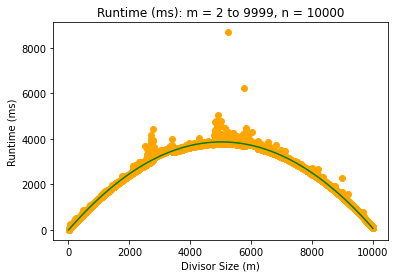

In [28]:
divisor_df['divisor_size_square'] = divisor_df['divisor_size']**2
results = smf.ols(formula='runtime ~ divisor_size + divisor_size_square', data=divisor_df).fit()
divisor_df['regression'] = results.fittedvalues
plt.scatter(divisor_df['divisor_size'], divisor_df['runtime'], color='orange') 
plt.plot(divisor_df['divisor_size'], divisor_df['regression'], color='green')
plt.title('Runtime (ms): m = 2 to 9999, n = 10000')
plt.xlabel('Divisor Size (m)')
plt.ylabel('Runtime (ms)')
print(results.summary())
plt.savefig('divisor.png')

(array([3.320e+02, 4.080e+02, 4.320e+02, 4.470e+02, 4.680e+02, 5.020e+02,
        5.290e+02, 5.990e+02, 6.510e+02, 6.890e+02, 5.840e+02, 1.206e+03,
        1.940e+03, 1.117e+03, 7.800e+01, 1.000e+01, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([6.00000000e+00, 2.95166667e+02, 5.84333333e+02, 8.73500000e+02,
        1.16266667e+03, 1.45183333e+03, 1.74100000e+03, 2.03016667e+03,
        2.31933333e+03, 2.60850000e+03, 2.89766667e+03, 3.18683333e+03,
        3.47600000e+03, 3.76516667e+03, 4.05433333e+03, 4.34350000e+03,
        4.63266667e+03, 4.92183333e+03, 5.21100000e+03, 5.50016667e+03,
        5.78933333e+03, 6.07850000e+03, 6.36766667e+03, 6.65683333e+03,
        6.94600000e+03, 7.23516667e+03, 7.52433333e+03, 7.81350000e+03,
        8.10266667e+03, 8.39183333e+03, 8.68100000e+03]),
 <a list of 30 Patch objects>)

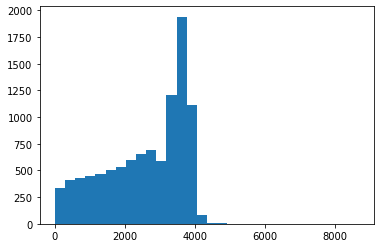

In [29]:
plt.hist(divisor_df['runtime'], bins=30)

In [30]:
print(f'runtime skew = {skew(divisor_df["runtime"])}')
print(f'runtime kurtosis {kurtosis(divisor_df["runtime"], fisher=False)}')

runtime skew = -0.5906818055727012
runtime kurtosis 2.1884923856929657


In [31]:
print(results.tvalues)

Intercept                -3.888035
divisor_size           1153.020022
divisor_size_square   -1185.473905
dtype: float64


## Evaluate $F(m)$ Error Behavior

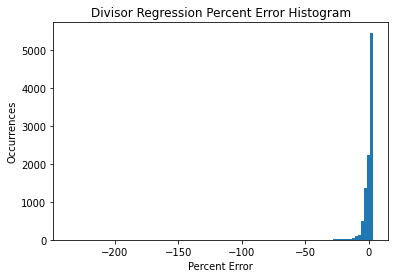

In [32]:
divisor_df['runtime'] = divisor_df['runtime'].replace(0, .1)
divisor_df['pct_err'] = 100*(divisor_df['regression'] - divisor_df['runtime'])/divisor_df['runtime']
plt.hist(divisor_df['pct_err'], bins=100)
plt.title('Divisor Regression Percent Error Histogram')
plt.xlabel('Percent Error')
plt.ylabel('Occurrences')
plt.savefig('divisor_hist.png')

## Sample Statistical Moments
Sample moments indicate extremely high peak with very large tails, and strong negative skew - tendency to underestimate runtimes¶

In [33]:
print(f'Mean = {round(np.mean(divisor_df["pct_err"]), 3)}')
print(f'Variance = {round(np.var(divisor_df["pct_err"]), 3)}')
print(f'Skew = {round(skew(divisor_df["pct_err"]), 3)}')
print(f'Kurtosis = {round(kurtosis(divisor_df["pct_err"]), 3)}')

Mean = -0.584
Variance = 35.824
Skew = -16.527
Kurtosis = 469.98


In [34]:
divisor_df['pct_err'].describe()

count    9998.000000
mean       -0.583528
std         5.985617
min      -236.202631
25%        -1.337240
50%         1.022642
75%         1.655003
max         3.176226
Name: pct_err, dtype: float64